In [ ]:
# Download the dataset
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wanderdust/skin-lesion-analysis-toward-melanoma-detection

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 11.3G/11.3G [01:19<00:00, 201MB/s]
100% 11.3G/11.3G [01:19<00:00, 154MB/s]


In [ ]:
# Unzip the dataset
from zipfile import ZipFile

with ZipFile("/content/skin-lesion-analysis-toward-melanoma-detection.zip","r") as dataset:
  dataset.extractall()

In [ ]:
import itertools
import os

import matplotlib.pylab
import numpy

import tensorflow

In [ ]:

import tensorflow_datasets

train_data_dir="/content/skin-lesions/train"
test_data_dir="/content/skin-lesions/test"
batch_size = 32
img_height = 224
img_width = 224

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  train_data_dir,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 3 classes.


In [ ]:
val_ds = tensorflow.keras.utils.image_dataset_from_directory(
  test_data_dir,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 600 files belonging to 3 classes.


In [ ]:
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
img_shape=(224, 224, 3)
model  = tensorflow.keras.applications.vgg16.VGG16(input_shape=img_shape,
    #The Fully-Connected layer generates 1,000 different output labels, therefore  "cut off" the Fully-Connected layer - also called the "top" model.
    include_top=False,
    weights='imagenet',
    classifier_activation='softmax',
)

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model(image_batch)
print(feature_batch.shape)

global_average_layer = tensorflow.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tensorflow.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7, 7, 512)
(32, 512)
(32, 3)


In [ ]:
model.trainable = False

In [ ]:
preprocess_input = tensorflow.keras.applications.vgg16.preprocess_input
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = model(x, training=False)
x = global_average_layer(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tensorflow.keras.Model(inputs, outputs)
base_learning_rate = 0.001
initial_epochs = 10
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[callback])

Epoch 1/10
63/63 [==============================] - 301s 4s/step - loss: 1.8696 - accuracy: 0.5610 - val_loss: 1.2340 - val_accuracy: 0.5867
Epoch 2/10
63/63 [==============================] - 10s 154ms/step - loss: 1.2568 - accuracy: 0.6100 - val_loss: 1.0129 - val_accuracy: 0.6483
Epoch 3/10
63/63 [==============================] - 10s 155ms/step - loss: 0.9688 - accuracy: 0.6615 - val_loss: 0.9287 - val_accuracy: 0.6683
Epoch 4/10
63/63 [==============================] - 10s 155ms/step - loss: 0.9224 - accuracy: 0.6775 - val_loss: 0.8829 - val_accuracy: 0.6750
Epoch 5/10
63/63 [==============================] - 10s 156ms/step - loss: 0.8251 - accuracy: 0.6875 - val_loss: 0.8741 - val_accuracy: 0.6533
Epoch 6/10
63/63 [==============================] - 10s 161ms/step - loss: 0.7899 - accuracy: 0.7005 - val_loss: 0.8483 - val_accuracy: 0.6733
Epoch 7/10
63/63 [==============================] - 10s 157ms/step - loss: 0.7334 - accuracy: 0.7190 - val_loss: 0.8375 - val_accuracy: 0.6800
E

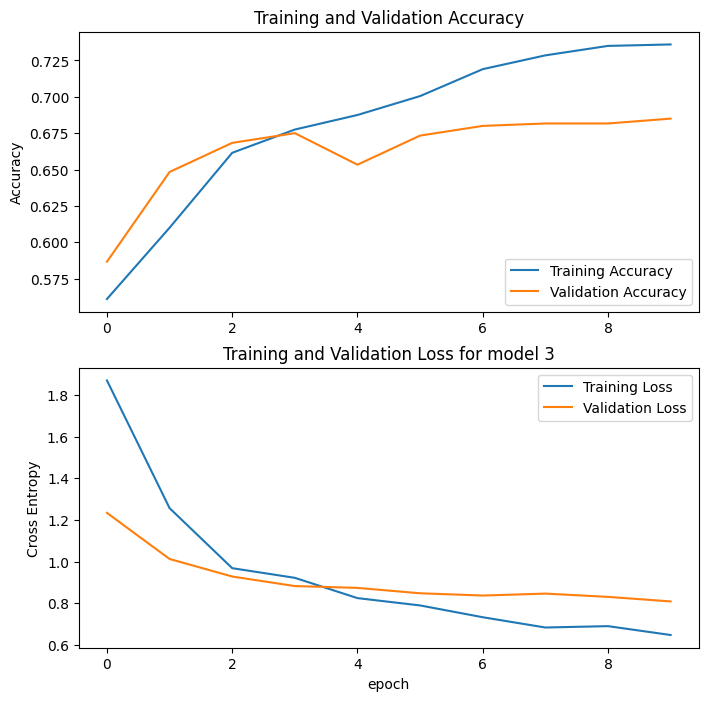

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

matplotlib.pyplot.figure(figsize=(8, 8))
matplotlib.pyplot.subplot(2, 1, 1)
matplotlib.pyplot.plot(acc, label='Training Accuracy')
matplotlib.pyplot.plot(val_acc, label='Validation Accuracy')
matplotlib.pyplot.legend(loc='lower right')
matplotlib.pyplot.ylabel('Accuracy')
# matplotlib.pyplot.ylim([min(matplotlib.pyplot.ylim()),1])
matplotlib.pyplot.title('Training and Validation Accuracy')

matplotlib.pyplot.subplot(2, 1, 2)
matplotlib.pyplot.plot(loss, label='Training Loss')
matplotlib.pyplot.plot(val_loss, label='Validation Loss')
matplotlib.pyplot.legend(loc='upper right')
matplotlib.pyplot.ylabel('Cross Entropy')
# matplotlib.pyplot.ylim([0,1.0])
matplotlib.pyplot.title('Training and Validation Loss for model 3')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.show()

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           